In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
tf.random.set_seed(42)

# scaling data to range 0-1
train_datagen = ImageDataGenerator(rescale=1./255)
valid_datagen = ImageDataGenerator(rescale=1./255)

# set path for data directories
train_dir = "/Users/korzeniewski/Downloads/10_food_classes_10_percent/train"
test_dir = "/Users/korzeniewski/Downloads/10_food_classes_10_percent/test"

# Import data and turn into batches
train_data = train_datagen.flow_from_directory(directory = train_dir,
                                                batch_size = 32, # size of mini batches
                                                target_size=(224, 224), # size of output image
                                                class_mode = "categorical", # type of data
                                                seed = 42)

valid_data = valid_datagen.flow_from_directory(directory = test_dir,
                                                batch_size = 32,
                                                target_size=(224, 224),
                                                class_mode = "categorical",
                                                seed = 42)

Found 2500 images belonging to 10 classes.
Found 750 images belonging to 10 classes.


In [3]:
# seting callbacks 
# Tracking experiment with TensorBoard
# model checkpoint ModelCheckpoint
# EarlyStoping

import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(lod_dir = log_dir)
    print(f"Saving TensorBoard log file to: {log_dir}")
    return tensorboard_callback

In [3]:
# create machine learning model with transfer learning
import tensorflow_hub as hub

IMAGE_SHAPE = (224, 224)

def create_model(model_url, num_classes = 10):
    feature_extracion_layer = hub.KerasLayer(model_url, input_shape=IMAGE_SHAPE+(3,))
    
    model = tf.keras.Sequential([
        feature_extracion_layer,
        tf.keras.layers.Dense(num_classes,activation='softmax')
    ])
    return model

model = create_model("https://tfhub.dev/tensorflow/efficientnet/b0/classification/1")

2022-08-02 14:28:39.633920: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [24]:
#model.summary()
# compile
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
            optimizer = tf.keras.optimizers.Adam(),
            metrics = ["accuracy"])
#fit
history = model.fit(train_data, #Image data generator crate sample with labels
                        epochs=4,
                        steps_per_epoch=len(train_data), # train_data/batches = 47
                        validation_data=valid_data,
                        validation_steps=len(valid_data))

Epoch 1/4
79/79 [==============================] - 236s 3s/step - loss: 2.2816 - accuracy: 0.3036 - val_loss: 2.2587 - val_accuracy: 0.4387
Epoch 2/4
79/79 [==============================] - 226s 3s/step - loss: 2.2327 - accuracy: 0.5452 - val_loss: 2.2138 - val_accuracy: 0.5707
Epoch 3/4
79/79 [==============================] - 228s 3s/step - loss: 2.1845 - accuracy: 0.6200 - val_loss: 2.1706 - val_accuracy: 0.6120
Epoch 4/4
79/79 [==============================] - 256s 3s/step - loss: 2.1380 - accuracy: 0.6544 - val_loss: 2.1281 - val_accuracy: 0.6320


[[0.09591334 0.09565404 0.09486558 0.08739086 0.09482632 0.08753717
  0.16666907 0.09766698 0.09245951 0.08701716]]


Text(0.5, 1.0, 'Prediction is: pizza')

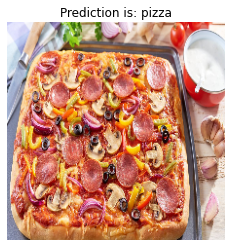

In [31]:
import matplotlib.image as mpimg
import random
import pathlib

data_dir = pathlib.Path("/Users/korzeniewski/Downloads/10_food_classes_all_data/test")
class_names = np.array(sorted(item.name for item in data_dir.glob("*")))

def load_and_prep_image(path, img_shape=224):
    img = mpimg.imread(path)
    img = tf.constant(img)
    img = tf.image.resize(img, size= [img_shape, img_shape])
    img = img/255
    return img

img=load_and_prep_image(path = '/Users/korzeniewski/Downloads/pizza-rodzinna.jpg')

pred = model.predict(tf.expand_dims(img, axis = 0))
print(pred)
plt.imshow(img)
plt.axis(False)
plt.title("Prediction is: " + class_names[pred.argmax()])

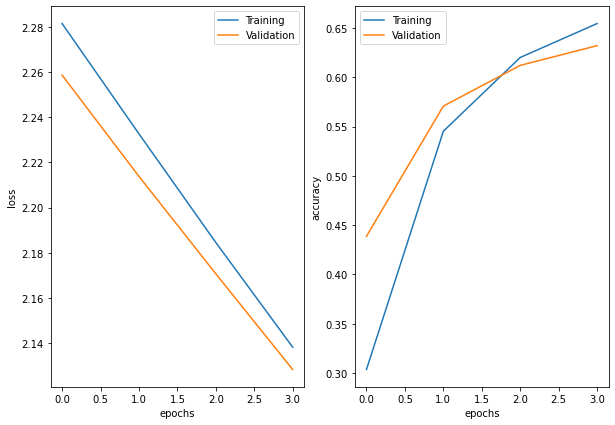

In [32]:
# evaluate model
pd.DataFrame(history.history)
loss = history.history["loss"]
val_loss = history.history["val_loss"]
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

epochs = range(len(val_acc))

plt.figure(figsize=(10,7))
plt.subplot(1,2,1)
plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend(["Training", "Validation"])

plt.subplot(1,2,2)
plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.legend(["Training", "Validation"])

## USE FUNCTIONAL API

In [13]:
import helper_function as hp
# tf.keras.applications will be used to work with the data

test_dir = "/Users/korzeniewski/Downloads/10_food_classes_10_percent/train"
train_dir = "/Users/korzeniewski/Downloads/10_food_classes_10_percent/test"

IMG_SIZE = (32,32)
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory = train_dir,
                                                                image_size = IMAGE_SHAPE,
                                                                label_mode = "categorical",
                                                                batch_size = 32)

test_data = tf.keras.preprocessing.image_dataset_from_directory(directory = test_dir,
                                                                image_size = IMAGE_SHAPE,
                                                                label_mode = "categorical",
                                                                batch_size = 32)

Found 750 files belonging to 10 classes.
Found 2500 files belonging to 10 classes.


In [14]:
for image, labels in train_data.take(1):
    print(image) 
    print(labels)

tf.Tensor(
[[[[1.17285713e+02 9.32857132e+01 6.92857132e+01]
   [1.17285713e+02 9.32857132e+01 6.92857132e+01]
   [1.17780617e+02 9.37806168e+01 6.97806168e+01]
   ...
   [1.99852020e+02 2.07852020e+02 2.10852020e+02]
   [1.97617325e+02 2.04760208e+02 2.10688766e+02]
   [1.95357147e+02 2.04357147e+02 2.09357147e+02]]

  [[1.20928574e+02 9.69285736e+01 7.10714264e+01]
   [1.20928574e+02 9.69285736e+01 7.10714264e+01]
   [1.21872452e+02 9.78724518e+01 7.20153046e+01]
   ...
   [1.93428543e+02 2.01428543e+02 2.04428543e+02]
   [1.93005081e+02 2.01010193e+02 2.04352051e+02]
   [1.91142853e+02 2.00142853e+02 2.05142853e+02]]

  [[1.23214287e+02 9.72142868e+01 7.17857132e+01]
   [1.24142860e+02 9.81428604e+01 7.27142868e+01]
   [1.24214287e+02 9.82142868e+01 7.27857132e+01]
   ...
   [1.89785721e+02 1.97785721e+02 2.00785721e+02]
   [1.89928558e+02 1.98071442e+02 2.01000000e+02]
   [1.90000000e+02 2.00000000e+02 2.02000000e+02]]

  ...

  [[2.21719376e+02 2.21719376e+02 2.13719376e+02]
   [2

In [59]:
# using functional API - give us flexibility

# adding data augemntation as layer in model; is working on GPU
data_augemntation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2) #also can add Rascale()
], name = "data_augmentation")


#model 0: transfer learning model
# 1. Create model tf.keras.applications allowed to load pre training models
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
#2. Freeze the base model
base_model.trainable = False

#3. Create inputs
inputs = tf.keras.layers.Input(shape = (224,224,3), name = "input_layer")
x = data_augemntation(inputs)
#4. nomralize inputs if used ResNet (efficent net is autmaticly rescaling)
#x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(inputs)

#5. Pass inputs to base model
x = base_model(x, training = False)
print("Shape after passing inputs through base model: {}".format(x.shape))

#6. aggregate all the 
x = tf.keras.layers.GlobalAveragePooling2D(name = "global")(x)
print(print("Shape after globall pooling: {}".format(x.shape)))

#7. create outputs
outputs = tf.keras.layers.Dense(10, activation = "softmax")(x)

# 8. combine
model_0 = tf.keras.Model(inputs, outputs)

# compile model
model_0.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
            optimizer = tf.keras.optimizers.Adam(),
            metrics = ["accuracy"])

model_0.summary()


Shape after passing inputs through base model: (None, 7, 7, 1280)
Shape after globall pooling: (None, 1280)
None
Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global (GlobalAveragePoolin  (None, 1280)             0         
 g2D)                                                            
                                                                 
 dense_13 (Dense)            (None, 10)                12810     
           

In [61]:
# creating model callback
# tf.keras.callbacks.ModelCheckpoint()

# fit model
history = model_0.fit(train_data, #Image data generator crate sample with labels
                        epochs=4,
                        steps_per_epoch=len(train_data),
                        validation_data = test_data,
                        validation_steps = len(test_data)*0.1)

Epoch 1/4
24/24 [==============================] - 115s 4s/step - loss: 1.9946 - accuracy: 0.3493 - val_loss: 1.4561 - val_accuracy: 0.6758
Epoch 2/4
24/24 [==============================] - 76s 3s/step - loss: 1.3176 - accuracy: 0.6787 - val_loss: 1.0264 - val_accuracy: 0.8008
Epoch 3/4
24/24 [==============================] - 78s 3s/step - loss: 0.9886 - accuracy: 0.7667 - val_loss: 0.8259 - val_accuracy: 0.8047
Epoch 4/4
24/24 [==============================] - 79s 3s/step - loss: 0.8138 - accuracy: 0.8107 - val_loss: 0.7279 - val_accuracy: 0.8203


[[0.10853886 0.08378112 0.11522969 0.10869543 0.08377622 0.06769051
  0.13206057 0.11519498 0.10126258 0.08376999]]


Text(0.5, 1.0, 'Prediction is: pizza')

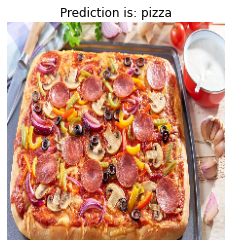

In [23]:
img=hp.load_and_prep_image('/Users/korzeniewski/Downloads/pizza-rodzinna.jpg')
train_data.class_names

pred = model_0.predict(tf.expand_dims(img, axis = 0))
print(pred)
plt.imshow(img)
plt.axis(False)
plt.title("Prediction is: " + train_data.class_names[pred.argmax()])

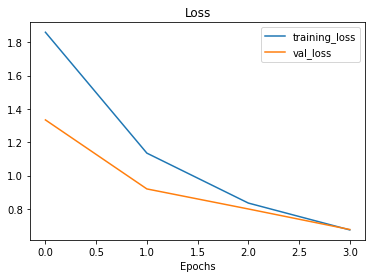

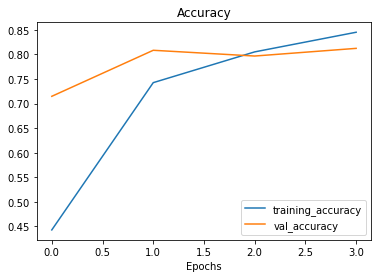

In [31]:
hp.plot_loss_curves(history)

In [32]:
model_0.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 data_augmentation (Sequenti  (None, 7, 7, 1280)       0         
 al)                                                             
                                                                 
 global (GlobalAveragePoolin  (None, 1280)             0         
 g2D)                                                            
                                                                 
 dense_5 (Dense)             (None, 10)                12810     
                                                                 
Total params: 4,062,381
Trainable params: 12,810
Non-traina

In [45]:
# layers in efficient net
for i, layer in enumerate(model_0.layers[2].layers):
    print(i, layer.name, layer.trainable)

0 input_16 False
1 rescaling_15 False
2 normalization_15 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_re

## Making fine tuning learning some part of pre-learned model

In [63]:
# setting last ten layers of based model as fine tuning
base_model.trainable = False

# Freeze all layers expect last ten
for layer in base_model.layers[-10:]:
    print(layer.name) 
    layer.trainable = True

block7a_se_squeeze
block7a_se_reshape
block7a_se_reduce
block7a_se_expand
block7a_se_excite
block7a_project_conv
block7a_project_bn
top_conv
top_bn
top_activation


In [64]:
# after making some changes in model we have to recompile it
model_0.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0001), #in fune tuning we want small learning rate
                metrics = ["accuracy"])

In [65]:
history_fine = model_0.fit(train_data, #Image data generator crate sample with labels
                        epochs=8,
                        steps_per_epoch=len(train_data),
                        validation_data = test_data,
                        validation_steps = len(test_data)*0.1,
                        initial_epoch = history.epoch[-1] #start training fine tuning after correct epeoch
                        )

Epoch 4/8
24/24 [==============================] - 113s 4s/step - loss: 0.7411 - accuracy: 0.8160 - val_loss: 0.7189 - val_accuracy: 0.8359
Epoch 5/8
24/24 [==============================] - 90s 4s/step - loss: 0.7172 - accuracy: 0.8347 - val_loss: 0.6889 - val_accuracy: 0.8438
Epoch 6/8
24/24 [==============================] - 84s 3s/step - loss: 0.7175 - accuracy: 0.8267 - val_loss: 0.6767 - val_accuracy: 0.8438
Epoch 7/8
24/24 [==============================] - 88s 4s/step - loss: 0.6924 - accuracy: 0.8347 - val_loss: 0.6860 - val_accuracy: 0.8477
Epoch 8/8
24/24 [==============================] - 96s 4s/step - loss: 0.6899 - accuracy: 0.8227 - val_loss: 0.6587 - val_accuracy: 0.8398


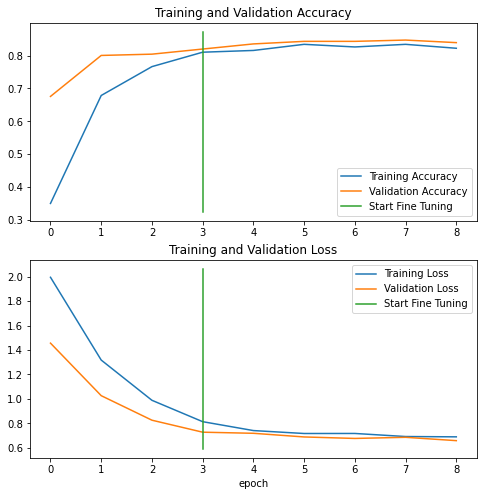

In [67]:
hp.compare_historys(history, history_fine, 4)